# Домашняя работа 3. Логистическая регрессия. Работа с датасетом Card Moldova

## Подготовка

Импортируем библиотеки

In [ ]:
import pandas as pd
from google.colab import files 

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Класс линейной регрессии без регуляризации

In [ ]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
                self.weights = np.append(self.bias,self.weights)
    
    #метод для прямого распространения
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #метод для рассчета функции потерь
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #метод для рассчета градиента
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #метод для обновления весов
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #метод для инициализации весов
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #метод для добавления колонки смещения
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #метод для предсказания значений целевой переменной с текущими весами 
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #метод для оценки работы модели
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #метод для формирования и загрузки бэтча
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #метод обучения модели
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        # в начале инициализируются веса и смещение и совмещаются в один массив
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        # инициализация градиента, потерь и загрузка батча
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #функция построения графика потерь для проверки работы алгоритма
    def plot_cost(self, figsize = (8,4), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 18)
        plt.ylabel('Функция Потерь', fontsize = 18)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #функция, возвращающая текущие значения весов и смещения
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

Класс линейной регрессии с эластичной регуляризацией (L1 и L2)

In [ ]:
class ElasticRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.001,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state)
        self.l1_penalty = l1_penalty
        self.l2_penalty = l2_penalty
    #рассчет потерь с учетом "штрафа" за размер весов
    def loss(self,yhat, y):   
        l1_term = self.l1_penalty*np.sum(self.weights[1:])
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l1_term + l2_term
                  
    
    #прямое распространение
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad +  np.sign(self.weights)*self.l1_penalty + l2_term)

Класс логистической регрессии с эластичной регуляризацией

In [ ]:
_EPS_ = 1e-6

class LogisticRegression(ElasticRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l1_penalty = 0.0,
                 l2_penalty = 0.0,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 threshold = 0.5,
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state,
                         l1_penalty = l1_penalty,
                         l2_penalty = l2_penalty)       
        self.learning_rate = learning_rate/2
        self.threshold = threshold
    
    #Функция потерь (cross-entropy) с учетом "штрафов" за размер весов
    def loss(self,yhat, y):
        
        l1_term = self.l1_penalty*np.sum(self.weights[1:])/y.size
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))/y.size
        
        return -(y*np.log(yhat  + _EPS_)+(1 - y)*np.log(1 - yhat  + _EPS_)).mean()\
            + l1_term+ l2_term 
    
    #Функция активации для рассчета вероятности принадлежности точки к классу 1
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z)) 
    
    #Прямое распространение
    def forward(self, X):        
        return self.sigmoid(self.weights.dot(X.T))
    
    #Определение класса на основании logit, определенного с помощью сигмоиды
    def to_class(self,logit):
        return (logit>=self.threshold)*1
    
    #Предсказание значений целевок переменной для текущего состояния модели
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        
        if self.threshold:
            return self.to_class(yhat)
        else:
            return yhat
    #Оценка работы модели
    def score(self, X, y):
        yhat  = self.predict(X)
        return sum((yhat==y)*1)/y.size
    
    #Вывод оценки результатов классификации: распределение верных и неверных результатов, точность, специфичность и другие метрики
    def classification_report(self, X,y):
        tp = 0 # true_positives
        tn = 0 # true_negatives
        fp = 0 # false_positives
        fn = 0 # false_negatives
        
        yhat  = self.predict(X)
        total = yhat.size
        
        for yhati,yi in zip(yhat,y):
            if yi == 1 and yhati == 1:
                tp += 1
            elif yi == 0 and yhati == 0:
                tn += 1
            elif yi == 1 and yhati == 0:
                fn += 1
            elif yi == 0 and yhati == 1:
                fp += 1

        print('True Positives:%.0f'%(tp), end = '\t')
        print('False Positives:%.0f'%(fp))
        print('False Negatives:%.0f'%(fn), end = '\t')
        print('True Negatives:%.0f'%(tn))
        
        print('Accuracy:%.4f'% ((tp + tn) / total))
        print('Recall:%.4f'% (tp / (tp + fn)), end = '\t')
        print('Precision:%.4f'%(tp / (tp + fp)))
        print('f1 measure:%.4f'%(tp / (tp + 0.5*(fp+fn))))

## Формирование тестовой и тренировочной выборок

Загрузка датасета

In [ ]:
uploaded = files.upload()

Saving cars_moldova_processed.csv to cars_moldova_processed.csv


In [ ]:
df = pd.read_csv('/content/cars_moldova_processed.csv')

Списки столбцов с числовыми и категориальными данными

In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'km_category', 'engine_category']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'Age', 'km_year']

Заменим категориальные значения в столбце целевой переменной на числовые

In [ ]:
df['Transmission'] = df['Transmission'].replace('Automatic', 1)
df['Transmission'] = df['Transmission'].replace('Manual', 0)

In [ ]:
df.head(7)

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,km_category,Engine_capacity(litre),engine_category
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,1,7750.0,11,17727.272727,Middle,1.80,Small
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,0,8550.0,8,16875.000000,Middle,1.50,Small
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,0,6550.0,10,11000.000000,Middle,1.50,Small
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,0,4100.0,16,12500.000000,Middle,1.60,Small
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,0,3490.0,22,13636.363636,Middle,2.20,Medium
5,Volkswagen,Passat,2010,Universal,290000.0,1390.0,Petrol,0,5600.0,12,24166.666667,Big,1.39,Small
6,Volkswagen,Touareg,2010,SUV,220000.0,2400.0,Diesel,1,17000.0,12,18333.333333,Middle,2.40,Medium


Разбиваем на тренировочную и тестовые выборки

In [ ]:
X = df[num_columns].values  
y = df["Transmission"].values # Целевая переменная -- тип трансмиссии
features_names = df[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5
22549,0.40,0.011012,0.291667,0.006513,0.60,0.005179
22550,0.74,0.208921,0.270833,0.061112,0.26,0.297166
22551,0.84,0.155127,0.270833,0.078146,0.16,0.343601
22552,0.84,0.219922,0.229167,0.066132,0.16,0.487865
22553,0.94,0.049905,0.375000,0.251503,0.06,0.248497


## Реализация логистической регрессии с эластичной регуляризацией

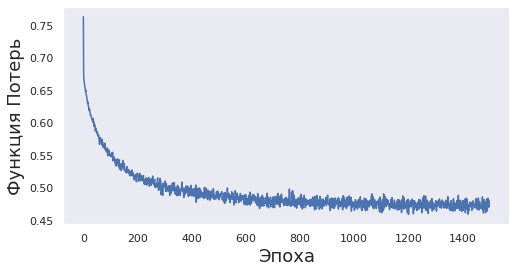

train Accuracy: 0.8040; test Accuracy: 0.8051
True Positives:3252	False Positives:731
False Negatives:1153	True Negatives:4530
Accuracy:0.8051
Recall:0.7383	Precision:0.8165
f1 measure:0.7754


In [ ]:
regr = LogisticRegression(learning_rate=0.8,epochs=1500,batch_size=5000, l1_penalty = 0.008, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

## Оценка весов

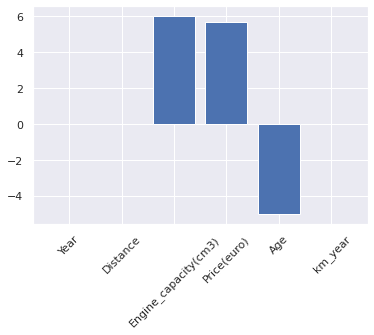

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Как мы видим по полученной гистограмме, наиболее значимыми параметрами являются цена и объем двигателя, за которыми следует возраст автомобила. Остальные признаки имеют минимальные веса.

## Работа с данными с различными типами предварительной обработки

Для оценки результатов с различными типами предварительной обработки загрузим файлы, созданные в домашней работе 1

### cars_power - степенное преобразование.

In [ ]:
up_power = files.upload()

Saving cars_power.csv to cars_power.csv


In [ ]:
cars_power = pd.read_csv('/content/cars_power.csv')

Переводим тип трансмиссии в числовой формат

In [ ]:
cars_power['Transmission'] = cars_power['Transmission'].replace('Automatic', 1)
cars_power['Transmission'] = cars_power['Transmission'].replace('Manual', 0)

Разделяем на тренировочную и тестовую выборки

In [ ]:
X = cars_power[num_columns].values  
y = cars_power["Transmission"].values
features_names = cars_power[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5
22549,0.403011,0.511438,0.646015,0.232825,0.60,0.005179
22550,0.742400,0.830037,0.625965,0.555116,0.26,0.297166
22551,0.841674,0.797731,0.625965,0.593562,0.16,0.343601
22552,0.841674,0.835606,0.581508,0.567431,0.16,0.487865
22553,0.940701,0.674743,0.715338,0.778849,0.06,0.248497


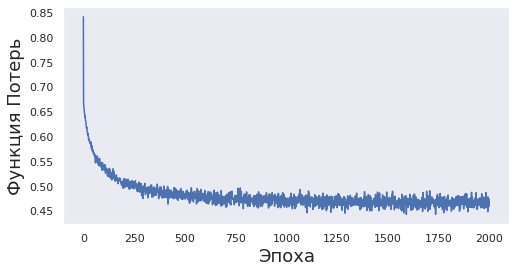

train Accuracy: 0.7950; test Accuracy: 0.7996
True Positives:3315	False Positives:847
False Negatives:1090	True Negatives:4414
Accuracy:0.7996
Recall:0.7526	Precision:0.7965
f1 measure:0.7739


In [ ]:
regr = LogisticRegression(learning_rate=0.8, epochs=2000, batch_size=5000, l1_penalty = 0.000001, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

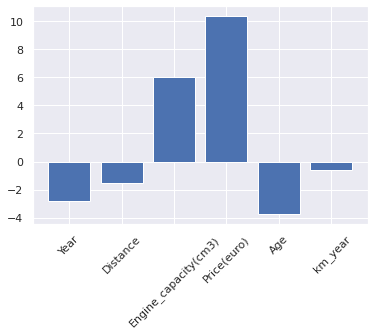

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Самым значимым признаком является цена автомобиля. Второй по значимости -- объем двигателя. Самый незначительный -- удельный пробег в год.

### cars_norm - normalization

In [ ]:
up_norm = files.upload()

Saving cars_normalization.csv to cars_normalization.csv


In [ ]:
cars_norm = pd.read_csv('/content/cars_normalization.csv')

In [ ]:
cars_norm['Transmission'] = cars_norm['Transmission'].replace('Automatic', 1)
cars_norm['Transmission'] = cars_norm['Transmission'].replace('Manual', 0)

In [ ]:
X = cars_norm[num_columns].values  
y = cars_norm["Transmission"].values
features_names = cars_norm[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5
22549,0.40,0.011012,0.291667,0.006513,0.60,0.005179
22550,0.74,0.208921,0.270833,0.061112,0.26,0.297166
22551,0.84,0.155127,0.270833,0.078146,0.16,0.343601
22552,0.84,0.219922,0.229167,0.066132,0.16,0.487865
22553,0.94,0.049905,0.375000,0.251503,0.06,0.248497


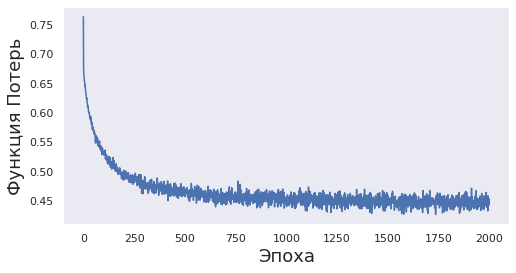

train Accuracy: 0.8080; test Accuracy: 0.8125
True Positives:3281	False Positives:688
False Negatives:1124	True Negatives:4573
Accuracy:0.8125
Recall:0.7448	Precision:0.8267
f1 measure:0.7836


In [ ]:
regr = LogisticRegression(learning_rate=0.8, epochs=2000, batch_size=5000, l1_penalty = 0.000001, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

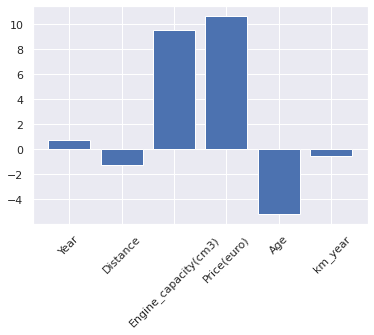

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

Как и раньше, самые значительные признаки -- объем двигателя и цена.

Изменим гиперпараметры, чтобы улучшить модель

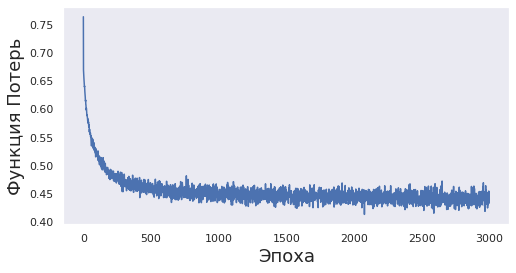

train Accuracy: 0.8094; test Accuracy: 0.8158
True Positives:3285	False Positives:660
False Negatives:1120	True Negatives:4601
Accuracy:0.8158
Recall:0.7457	Precision:0.8327
f1 measure:0.7868


In [ ]:
regr = LogisticRegression(learning_rate=1, epochs=3000, batch_size=5000, l1_penalty = 0.000001, l2_penalty = 0.000001)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

### cars_standard - standartization

In [ ]:
up_st = files.upload()

Saving cars_standartization.csv to cars_standartization.csv


In [ ]:
cars_standard = pd.read_csv('/content/cars_standartization.csv')

In [ ]:
cars_standard['Transmission'] = cars_standard['Transmission'].replace('Automatic', 1)
cars_standard['Transmission'] = cars_standard['Transmission'].replace('Manual', 0)

In [ ]:
X = cars_standard[num_columns].values  
y = cars_standard["Transmission"].values
features_names = cars_standard[num_columns].columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5
22549,0.40,0.011012,0.291667,0.006513,0.60,0.005179
22550,0.74,0.208921,0.270833,0.061112,0.26,0.297166
22551,0.84,0.155127,0.270833,0.078146,0.16,0.343601
22552,0.84,0.219922,0.229167,0.066132,0.16,0.487865
22553,0.94,0.049905,0.375000,0.251503,0.06,0.248497


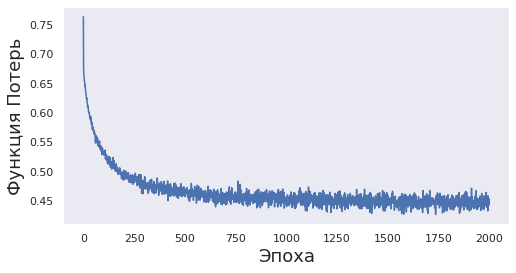

train Accuracy: 0.8080; test Accuracy: 0.8125
True Positives:3281	False Positives:688
False Negatives:1124	True Negatives:4573
Accuracy:0.8125
Recall:0.7448	Precision:0.8267
f1 measure:0.7836


In [ ]:
regr = LogisticRegression(learning_rate=0.8, epochs=2000, batch_size=5000, l1_penalty = 0.000001, l2_penalty = 0.00005)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

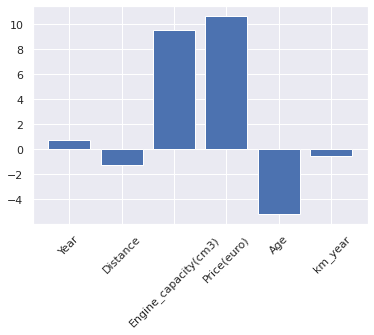

In [ ]:
w, b = regr.get_w_and_b()
plt.bar(x = range(w.size),height=w)
plt.xticks(range(w.size),features_names, rotation = 45 );

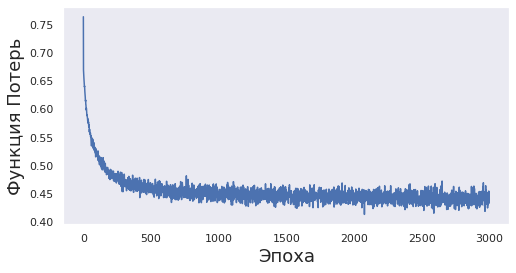

train Accuracy: 0.8094; test Accuracy: 0.8158
True Positives:3285	False Positives:660
False Negatives:1120	True Negatives:4601
Accuracy:0.8158
Recall:0.7457	Precision:0.8327
f1 measure:0.7868


In [ ]:
regr = LogisticRegression(learning_rate=1, epochs=3000, batch_size=5000, l1_penalty = 0.000001, l2_penalty = 0.000001)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

При одинаковых гиперпараметрах степенное преобразование немного ухудшает результат, в то время как нормализация и стандартизация дают более высокие результаты. 

### cars_ohe - one hot encoding

Создадим копию датафрейма с предварительной нормализацией и заменим все категориальные признаки на числовые с помощью OHE

In [ ]:
cars_ohe = cars_norm.copy()
cars_ohe = pd.get_dummies(cars_ohe)

In [ ]:
df_num_p = cars_ohe.copy()

X = df_num_p.drop(columns = 'Transmission').values
features_names = df_num_p.drop(columns = 'Transmission').columns

y = df_num_p['Transmission'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test) 
pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,...,844,845,846,847,848,849,850,851,852,853
22549,0.40,0.011012,0.291667,0.006513,0.60,0.005179,0.291667,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
22550,0.74,0.208921,0.270833,0.061112,0.26,0.297166,0.270833,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22551,0.84,0.155127,0.270833,0.078146,0.16,0.343601,0.270833,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22552,0.84,0.219922,0.229167,0.066132,0.16,0.487865,0.229167,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
22553,0.94,0.049905,0.375000,0.251503,0.06,0.248497,0.375000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


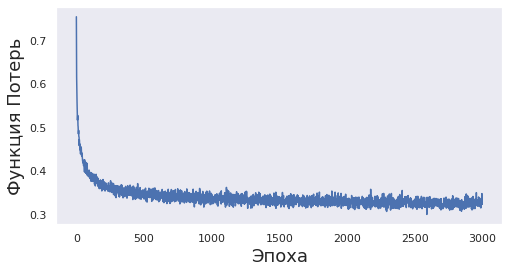

train Accuracy: 0.8599; test Accuracy: 0.8606
True Positives:3585	False Positives:527
False Negatives:820	True Negatives:4734
Accuracy:0.8606
Recall:0.8138	Precision:0.8718
f1 measure:0.8418


In [ ]:
regr = LogisticRegression(learning_rate=1, epochs=3000, batch_size=5000, l1_penalty = 0.000001, l2_penalty = 0.000001)

regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train Accuracy: %.4f; test Accuracy: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

regr.classification_report(X_test, y_test)

Точность возросла в сравнении с применением регрессией к только числовым признакам

## Выводы

Используя one hot encoding в сочетании с нормализацией удалось добиться более высоких результатов как на тестовой, так и на тренировочной выборках.

Проанализировав веса моделей, можно установить, что наиболее значимые признаки для предсказания типа трансмиссии -- цена и объем двигателя автомобиля.Также существенное влияние оказывает возраст, в то время как остальные признаки влияют в гораздо меньшей степени. 